# Sentiment Analysis with LSTMs

In this notebook, we'll be looking at how to apply deep learning techniques to the task of sentiment analysis. Sentiment analysis can be thought of as the exercise of taking a sentence, paragraph, document, or any piece of natural language, and determining whether that text's emotional tone is positive, negative or neutral. 

This notebook will go through the general steps involved with all machine learning problems. Also, it will cover numerous topics like word vectors, recurrent neural networks, and long short-term memory units (LSTMs). Don't get discouraged if you don't get a full understanding of what these terms mean at the first go. There will be links provided for additional reading on these topics.

Before getting into the specifics, let's discuss the reasons why deep learning fits into natural language processing (NLP) tasks. 

## Deep Learning for NLP 

Natural language processing is all about creating systems that process or “understand” language in order to perform certain tasks. These tasks could include:

* Question Answering - The main job of technologies like Siri, Alexa, and Cortana
* Sentiment Analysis - Determining the emotional tone behind a piece of text
* Image to Text Mappings - Generating a caption for an input image
* Machine Translation - Translating a paragraph of text to another language
* Speech Recognition - Having computers recognize spoken words

In the pre-deep learning era, NLP was a thriving field that saw lots of different advancements. However, in all of the successes in the aforementioned tasks, one needed to do a lot of data transformations and feature engineering (e.g. stopwords, stemming, part-of-speech tags, etc.) and thus had to have a lot of domain knowledge in linguistics. Entire 4 year degrees are devoted to this field of study, as practitioners needed to be comfortable with terms like phonemes and morphemes. In the past few years, deep learning has seen incredible progress and has largely removed the requirement of strong domain knowledge. As a result of the lower barrier to entry, applications to NLP tasks have been one of the biggest areas of deep learning research. 

## Extract the Data 

Since we are using Google Colaboratory, we need to get the data from Github:

**(Note: ONLY PERFORM THIS STEP IF YOU ARE USING THE GOOGLE COLABORATORY VERIOSN OF THIS NOTEBOOK. You only need to do this once. The repo will persist on the GCE instance your notbook is attached to)**

In [ ]:
#!git clone https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis.git

We then need to unzip the data files:

In [ ]:
!tar -xzf models.tar.gz
!tar -xzf training_data.tar.gz

Luckily we have the data in a nice format that is easily accessible. The dataset we're going to use is the Imdb movie review dataset. This set has 25,000 movie reviews, with 12,500 positive reviews and 12,500 negative reviews. Each of the reviews is stored in a txt file that we need to parse through. The positive reviews are stored in one directory and the negative reviews are stored in another. 

Since the data is relatively small in size in our example, we will wimple read the reviews into memory as a Python list of Strings. In production datasets are often much larger. If it can be fit into memory, we would use optimized data structures such as Pandas dataframes. If not, we may wish to take a random sample so that it does fit into memory, or use tools such as Apache Spark on a cluster. 

In [1]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in 
                 listdir('positiveReviews/') if 
                 isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in 
                 listdir('negativeReviews/') if 
                 isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

Positive files finished
Negative files finished


## Explore the Data

The first step is to take a look at your data. The following code will show 5 random samples from each of the positive and negative reviews:

In [2]:
import random

def print_rand_review(positive = True, num_to_print=5):
  type_rev = "positive" if positive else "negative"
  print("{} random {} reviews:".format(num_to_print, type_rev))
  for x in range(num_to_print):
    with open(random.choice(positiveFiles), "r", encoding='utf-8') as f:
      print(f.readline())
      print()

In [3]:
print_rand_review()

5 random positive reviews:
One of the unsung gems of the 1980's, Scenes... features razor-sharp satire and outstanding performances from Arnetia Walker (how did she not get a ton of roles after this?)and Wallace Shawn. It's a delicious send-up of class warfare and the people in those classes. The writing is hilarious and the characters, while not subtle, are nuanced. And, sorry, but the Asian gangs (if you can call one Japanese guy extorting one of the other characters a "gang") were not put in for "sociological value" as another review implies they should been. The value here lies in what the movie is making fun of and in the sparklingly wicked way it does it. I found it creative, funny, and idiosyncratic.

when my sister said this movie was gonna be good i had second thoughts but i watched it and it was actually funny. basically the movie is made of a weird girl who goes to a small town where no one likes her and she just wants to go there and get the reading of her aunts will don so

In [4]:
print_rand_review(False)

5 random negative reviews:
First off, this really is my favorite film ever. I don't need to give anyone a description because every a**hole does that. I am literally obsessed with this practically bloodless, cheesy, lame effects having', boom-stick showing', badly edited, 80's metal horror masterpiece. The director (I heard) had hoped for a hit at the box office so that he could do sequels and have a FREDDY/JASON type of deal for himself. Damn, I wish that could've went down like that! The soundtrack's banging'. The acting's good....CHECK THIS MOFO OUT. and any die-hard fans out there, feel free to email and chat sometime. Midgetorgy....I can be found at YAHOO.

Watching film i was in very light mood and also this film is light but the end of the film is just unexpected which leaves a long lasting memories in one's mind.<br /><br />movie starts with Abhay and his profession of being witness during registrar marriage. Soha comes for marriage and his boyfriend doesn't, leaving Soha alone

As you can see the reviews are quite long which is good because the longer the review, the more information it contains.

As you can see the reviews are quite long which is bad because the longer the review, more we have to concern about the distance between words that have similar context.

The following piece of code will determine total and average number of words in each review.

In [5]:
numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 25000
The total number of words in the files is 5844680
The average number of words in the files is 233.7872


We can also use the Matplot library to visualize this data in a histogram format.

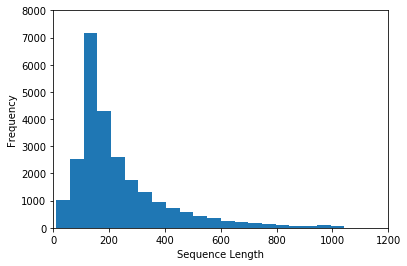

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

From the histogram as well as the average number of words per file, we can safely say that most reviews will fall under 250 words, which is the max sequence length value we will set.

In [7]:
maxSeqLength = 250

There are other ways you can explore this data such as counting the number of unique words in your corpus, using regex to detect URLs and see how many messages contain URLs, and looking at the distribution of word occurences. For the purpose of this exercise, we will end our data exploration here.

## Transform the Data

Data is rarely in the format that is useful for a machine learning algorithm. In our case, the most obvious transformation requirement is turning the text in a form that is not understood by ML algorithms (String) to a form that is understood by ML algorithms: a numerical vector (aka word vectors/embeddings).  

### Word Vectors

In order to understand how deep learning can be applied, think about all the different forms of data that are used as inputs into machine learning or deep learning models. Computer vision ML models use arrays of pixel values, and logistic regression uses quantifiable features. The common theme is that the inputs need to be scalar values, or matrices of scalar values. When you think of NLP tasks, however, a data pipeline like this may come to mind. 
 
![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis.png?raw=true)

This kind of pipeline is problematic. There is no way for us to do common operations in a neural network like dot products or backpropagation on a single string. Instead of having a string input, we will need to convert each word in the sentence to a vector. 

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis2.png?raw=true)

You can think of the input to the sentiment analysis module as being a 16 x D dimensional matrix. 

We want these vectors to be created in such a way that they somehow represent the word and its context, meaning, and semantics. For example, we’d like the vectors for the words “love” and “adore” to reside in relatively the same area in the vector space since they both have similar definitions and are both used in similar contexts. The vector representation of a word is also known as a word embedding.

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis8.png?raw=true)

The next subsection goes into a litle mroe detail _how_ word vectors are trained and how it encapsulates the semanticl and/or contextual meaning of a word in a numerical vector. We will skip this sub-section for now but read on if you're interested.

#### Aside: Word2Vec

In order to create these word embeddings, we'll use an *additional* model that's commonly refered to as "Word2Vec". Without going into too much detail, the model creates word vectors by looking at the context with which words appear in sentences. Words with similar contexts will be placed close together in the vector space. In natural language, the context of words can be very important when trying to determine their meanings. Taking our previous example of the words "adore" and "love", consider the types of sentences we'd find these words in.

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis9.png?raw=true)

From the context of the sentences, we can see that both words are generally used in sentences with positive connotations and generally precede nouns or noun phrases. This is an indication that both words have something in common and can possibly be synonyms. Context is also very important when considering grammatical structure in sentences. Most sentences will follow traditional paradigms of having verbs follow nouns, adjectives precede nouns, and so on. For this reason, the model is more likely to position nouns in the same general area as other nouns. The model takes in a large dataset of sentences (English Wikipedia for example) and outputs vectors for each unique word in the corpus. The output of a Word2Vec model is called an embedding matrix.

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis3.png?raw=true)

This embedding matrix will contain vectors for every distinct word in the training corpus. Traditionally, embedding matrices can contain over 3 million word vectors.

The Word2Vec model is trained by taking each sentence in the dataset, sliding a window of fixed size over it, and trying to predict the center word of the window, given the other words. Using a loss function and optimization procedure, the model generates vectors for each unique word. The specifics of this training procedure can get a little complicated, so we’re going to skip over the details for now, but the main takeaway here is that inputs into any Deep Learning approach to an NLP task will likely have word vectors as input.

For more information on the theory behind Word2Vec and how you create your own embeddings, check out Tensorflow's [tutorial](https://www.tensorflow.org/tutorials/word2vec)

### Using Word Vectors

If we had a very large corpus of movie reviews, we can train our own Word2Vec model. But people have done similar things before so for simplicity, we're going to be using a pretrained model. 

As one of the biggest players in the ML game, Google was able to train a Word2Vec model on a massive Google News dataset that contained over 100 billion different words! From that model, Google [was able to create 3 million word vectors](https://code.google.com/archive/p/word2vec/#Pre-trained_word_and_phrase_vectors), each with a dimensionality of 300. 

In an ideal scenario, we'd use those vectors, but since the word vectors matrix is quite large (3.6 GB!), we'll be using a much more manageable matrix that is trained using [GloVe](http://nlp.stanford.edu/projects/glove/), a similar word vector generation model. The matrix will contain 400,000 word vectors, each with a dimensionality of 50. 

We're going to be importing two different data structures, one will be a Python list with the 400,000 words, and one will be a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values. 

In [8]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


Just to make sure everything has been loaded in correctly, we can look at the dimensions of the vocabulary list and the embedding matrix.

In [9]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


We can also search our word list for a word like "baseball", and then access its corresponding vector through the embedding matrix.

In [10]:
baseballIndex = wordsList.index('baseball')
wordVectors[baseballIndex]

array([-1.93270004,  1.04209995, -0.78514999,  0.91033   ,  0.22711   ,
       -0.62158   , -1.64929998,  0.07686   , -0.58679998,  0.058831  ,
        0.35628   ,  0.68915999, -0.50598001,  0.70472997,  1.26639998,
       -0.40031001, -0.020687  ,  0.80862999, -0.90565997, -0.074054  ,
       -0.87674999, -0.62910002, -0.12684999,  0.11524   , -0.55685002,
       -1.68260002, -0.26291001,  0.22632   ,  0.713     , -1.08280003,
        2.12310004,  0.49869001,  0.066711  , -0.48225999, -0.17896999,
        0.47699001,  0.16384   ,  0.16537   , -0.11506   , -0.15962   ,
       -0.94926   , -0.42833   , -0.59456998,  1.35660005, -0.27506   ,
        0.19918001, -0.36008   ,  0.55667001, -0.70314997,  0.17157   ], dtype=float32)

Now that we have our vectors, our first step is taking an input sentence and then constructing the its vector representation. Recall that we capped the length of each review at 250 words. If we convert each word directly into it's 50-D vector representation (as shoen in the output of the cell above), each review will be represented as a 250 x 50. However, this isn't the most efficient use of memory since we're keeping duplicates of a word vector every time the word occurs in our corpus. Luckily, Tensorflow (and many other deep learnign frameworks) realizes this, provides a embedding lookup function built in so that we can simple transform each word into the *index* of the word in the embedding matrix.

Let's say that we have the input sentence "I thought the movie was incredible and inspiring". In order to get the word vectors, we will use Tensorflow's embedding lookup function. This function takes in two arguments, one for the embedding matrix (the wordVectors matrix in our case), and one for the ids of each of the words. The ids vector can be thought of as the integerized representation of the training set. This is basically just the row index of each of the words. Let's look at a quick example to make this concrete. 

In [11]:
import tensorflow as tf
seqLength = 10 #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
firstSentence = np.zeros((seqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


The data pipeline can be illustrated below.

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis5.png?raw=true)

The 10 x 50 output should contain the 50 dimensional word vectors for each of the 10 words in the sequence. 

In [12]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


We're not quite there yet. Notice that the reviews are written in normal mixed case, and it contains punctuation and some html tags such as ``<br />``.

If you then look at the 400,000 word vocabulary covered by the pre-trained GloVe vectors you will notice that all words are in lowercase, it contains some puncuation, and it contains no HTML tags. We will need to make transformations to the text before we convert it to the word list index. 

The following code will do help us do the following transformations:

* Lowercase all chars
* Keep only alphanumeric characters r
* Remove ``<br />``'s'. 

There are additional transformations we _can_ take (e.g. parsing by whitespace and punctuation "this. is. " -> "this . is . ") but this will suffice for now.

In [13]:
# Removes punctuation, parentheses, question marks, etc., and leaves only 
# alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [14]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(random.choice(positiveFiles)) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        try:
            firstFile[indexCounter] = wordsList.index(word)
        except ValueError:
            firstFile[indexCounter] = 399999 #Index of vector for unknown words
        indexCounter = indexCounter + 1
firstFile

array([ 21253,     14,      7,   3366,    461,    787,     38,     14,
         2713,  42284,     21,     71,  16313,  26903,      5, 114247,
           48,    122,      7,   1083,     14,      4,     30,    257,
            6,   2384,      3, 201534,   1781,     34,  21253,     31,
           84,   1019,      3,    222,    113,     71,  26903,      5,
       114247,  58544,    886,     71,     17, 201534,    275,      3,
           71,  11395,  45385,      5,     71,   2694,   1095,     67,
           14,    138,      4, 201534,   1083,     17, 201534,   1975,
            4,    498,    163,     21,   4643,     22, 201534,   1083,
           67,   3346, 201534,  11633,   1781,  12387,     61, 201534,
         4974,   2851,   4643,     67,    976,    163,   1220,    561,
           48,      3,     71,   2847,  32537,     17, 201534,    275,
            3,     71,   2694,   1095,     71,   1446,   3004,     14,
         2446,     67,      5, 201534,   1781,    168,    169,   1167,
      

Notice that we are padding messages shorter than 250 words with 0, and that all out of vocabulary (OOV) words (i.e. all words in our reviews not found in the 400,000 word covered by the GloVe vectors) have value 399999. It also may be smart here to look and see how many OOV words you have in your data. If there are too many OOV words you may need to use other pre-trained word vectors or train your own. We are going to make the assumption here that there are not too many OOV words in our data.

Now, let's convert our 25,000 reviews from strings to indices. We'll load in the movie training set and integerize it to get a 25000 x 250 matrix. This was a computationally expensive process, so you have the option of running the whole piece or load in a pre-computed IDs matrix.

In [ ]:
%%time 
"""RUN THIS CELL IF YOU WANT TO COMPUTE THE INTEGER INDICES"""
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for pf in positiveFiles:
   with open(pf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 

for nf in negativeFiles:
   with open(nf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 
#Pass into embedding function and see if it evaluates. 

np.save('idsMatrix', ids)

In [15]:
"""RUN THIS CELL IF YOU WANT TO LOAD THE MATRIX"""
ids = np.load('idsMatrix.npy')

### Training, Validation, and Testing Sets

For all machine learning problems, you will need to separate the data into training, validation, and testing sets. Below is a brief description of the purpose of each:

**Training**
* Used to train the model
* Randomly sampled into mini batches so that the model training can be done iteratively for each mini batch

**Validation**
* Used periodically through training (end of multipel min-batched) to spot for problems such as overfitting 
* Also used for tuning hyper-parameters and selection between different model architectures
* Cant hink of it as a quasi test set
* Can also be used for training if you do not have enough training data (Google "cross-validation")

**Testing**
* **NOT** used for training
* Used at the _**very end of all training when you have selected the model to put into production**_ to estimate how well the model will perform in the real world

There are conflicting views on the purpose and use of a testing set. From a purist's perspective, the testing set should be used once and only once to report the accuracy of the model you have chosen to put into production. If there are multiple models being experimented with, you should compare their accuracy levels with the _validation_ set. Once you have used your testign set to compare the accuracy of multiple models, you are effectively changing it into a validation set. The reason behind this is to avoid overfitting. We will not go into the details here so just remember to set aside data for testing and do not use it until you ahve chosen which model to put into production

There are many ways we can split the data into the aforementioned subsets. For our example, we will be assuming that the reviews are randomly sampled and ordered in their subdirectories (``LSTM-Sentiment-Analysis/positiveReviews/`` and ``LSTM-Sentiment-Analysis/negativeReviews/``). There are 12,500 reviews each for positive and negative respectivley, so for each type of review we will be taking 10500 for training, 1000 for validation, and 1000 for testing. 

In [16]:
from random import randint

def getTrainBatch(batchSize):
  labels = []
  arr = np.zeros([batchSize, maxSeqLength])
  for i in range(batchSize):
      if (i % 2 == 0): 
          num = randint(1,10500)
          labels.append([1,0])
      else:
          num = randint(14501,25000)
          labels.append([0,1])
      arr[i] = ids[num-1:num]
  return arr, np.array(labels)


def getTestSet():
  # truth labels
  labels = [[1,0]] * 1000
  neg_labels = [[0,1]] * 1000
  labels.extend(neg_labels)
  # features (the middle 2000)
  features = ids[11500:13500]
  return np.array(features), np.array(labels)


def getValidationSet():
  # truth labels
  labels = [[1,0]] * 1000
  neg_labels = [[0,1]] * 1000
  labels.extend(neg_labels)
  # features
  pos_features = ids[10500:11500]
  neg_features = ids[13500:14500]
  return np.vstack((pos_features, neg_features)), np.array(labels)

Let's see what each of the above function returns.

Training set mini-batches:

In [17]:
batchSize = 5
feat, lbl = getTrainBatch(batchSize)

In [18]:
print(feat.shape)
print(lbl.shape)

(5, 250)
(5, 2)


The whole test set:

In [19]:
feat, lbl = getTestSet()

In [20]:
print(feat.shape)
print(lbl.shape)

(2000, 250)
(2000, 2)


The whole validation set:

In [21]:
feat, lbl = getValidationSet()

In [22]:
print(feat.shape)
print(lbl.shape)

(2000, 250)
(2000, 2)


## Build, Train, Tune, and Test Model(s)

The next series of cells under the headings **Recurrent Neaural Networks (RNN)** and **Long Short Term Memory Units (LSTM)** goes into a bit more detail about _how_ recurrent neural networks work. If we have time, we can revisit this later. For the time being, just think of RNNs as a type of machine learning algorithm suited for time series or sequence data. For sentiment analysis with movie reviews, RNNs will not only look at the current word in the review when training and making predictions, but also words that appeared earlier in the review. LSTMs are mechanisms within RNNs that control how much importance to place on the current vs. previous words (or how much of the previous words to remember, hence the term "memory" units).

### Recurrent Neural Networks (RNNs)

Now that we have our word vectors as input, let's look at the actual network architecture we're going to be building. The unique aspect of NLP data is that there is a temporal aspect to it. Each word in a sentence depends greatly on what came before and comes after it. In order to account for this dependency, we use a recurrent neural network.  

The recurrent neural network structure is a little different from the traditional feedforward NN you may be accostumed to seeing. The feedforward network consists of input nodes, hidden units, and output nodes. 

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis17.png?raw=true)

The main difference between feedforward neural networks and recurrent ones is the temporal aspect of the latter. In RNNs, each word in an input sequence will be associated with a specific time step. In effect, the number of time steps will be equal to the max sequence length. 

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis18.png?raw=true)

Associated with each time step is also a new component called a hidden state vector h<sub>t</sub>. From a high level, this vector seeks to encapsulate and summarize all of the information that was seen in the previous time steps. Just like x<sub>t</sub> is a vector that encapsulates all the information of a specific word, h<sub>t</sub> is a vector that summarizes information from previous time steps.

The hidden state is a function of both the current word vector and the hidden state vector at the previous time step. The sigma indicates that the sum of the two terms will be put through an activation function (normally a sigmoid or tanh).

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis15.png?raw=true)

The 2 W terms in the above formulation represent weight matrices. If you take a close look at the superscripts, you’ll see that there’s a weight matrix W<sup>X</sup> which we’re going to multiply with our input, and there’s a recurrent weight matrix W<sup>H</sup> which is multiplied with the hidden state vector at the previous time step. W<sup>H</sup> is a matrix that stays the same across all time steps, and the weight matrix W<sup>X</sup> is different for each input. 

The magnitude of these weight matrices impact the amount the hidden state vector is affected by either the current vector or the previous hidden state. As an exercise, take a look at the above formula, and consider how h<sub>t</sub> would change if either W<sup>X</sup> or W<sup>H</sup> had large or small values. 

Let's look at a quick example. When the magnitude of W<sup>H</sup> is large and the magnitude of W<sup>X</sup> is small, we know that h<sub>t</sub> is largely affected by h<sub>t-1</sub> and unaffected by x<sub>t</sub>. In other words, the current hidden state vector sees that the current word is largely inconsequential to the overall summary of the sentence, and thus it will take on mostly the same value as the vector at the previous time step. 

The weight matrices are updated through an optimization process called backpropagation through time. 

The hidden state vector at the final time step is fed into a binary softmax classifier where it is multiplied by another weight matrix and put through a softmax function that outputs values between 0 and 1, effectively giving us the probabilities of positive and negative sentiment. 

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis16.png?raw=true)

### Long Short Term Memory Units (LSTMs) 

Long Short Term Memory Units are modules that you can place inside of reucrrent neural entworks. At a high level, they make sure that the hidden state vector h is able to encapsulate information about long term dependencies in the text. As we saw in the previous section, the formulation for h in traditional RNNs is relatively simple. This approach won't be able to effectively connect together information that is separated by more than a couple time steps. We can illiustrate this idea of handling long term dependencies through an example in the field of question answering. The function of question answering models is to take an a passage of text, and answer a question about its content. Let's look at the following example.

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis4.png?raw=true)

Here, we see that the middle sentence had no impact on the question that was asked. However, there is a strong connection between the first and third sentences. With a classic RNN, the hidden state vector at the end of the network might have stored more information about the dog sentence than about the first sentence about the number. Basically, the addition of LSTM units make it possible to determine the correct and useful information that needs to be stored in the hidden state vector.

Looking at LSTM units from a more technical viewpoint, the units take in the current word vector x<sub>t</sub> and output the hidden state vector h<sub>t</sub>. In these units, the formulation for h<sub>t</sub> will be a bit more complex than that in a typical RNN. The computation is broken up into 4 components, an input gate, a forget gate, an output gate, and a new memory container. 

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis10.png?raw=true)

Each gate will take in x<sub>t</sub> and h<sub>t-1</sub> (not shown in image) as inputs and will perform some computation on them to obtain intermediate states. Each intermediate state gets fed into different pipelines and eventually the information is aggregated to form h<sub>t</sub>. For simplicity sake, we won't go into the specific formulations for each gate, but it's worth noting that each of these gates can be thought of as different modules within the LSTM that each have different functions. The input gate determines how much emphasis to put on each of the inputs, the forget gate determines the information that we'll throw away, and the output gate determines the final h<sub>t</sub> based on the intermediate states. For more information on understanding the functions of the different gates and the full equations, check out Christopher Olah's great [blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Looking back at the first example with question “What is the sum of the two numbers?”, the model would have to be trained on similar types of questions and answers. The LSTM units would then be able to realize that any sentence without numbers will likely not have an impact on the answer to the question, and thus the unit will be able to utilize its forget gate to discard the unnecessary information about the dog, and rather keep the information regarding the numbers. 

### Building the RNN Model

As a quick review, so far we have done the following:

    1) Training a word vector generation model (such as Word2Vec) or loading pretrained word vectors (GloVe). teh result is a large matrix with each row reprresenting a word in our vocab
    2) Transforming each review from String to a list of IDs that refers to the row index of the word in the pre-trained word vector matrix
    3) Split the data set into training mini batches, validation set, and testing set
    
We will now:

    1) Define the compute graph for the RNN with LSTM units (fancy way of saying build the model)
    2) Define and iteratively execute the training step
    3) Validate with the validation set once every x training steps
    4) Calculate testing accuracy

Now, we’re ready to start creating our Tensorflow graph. We’ll first need to define some hyperparameters, such as batch size, number of LSTM units, number of output classes, number of training iterations, and the dimensions fo our word embeddings.

In [54]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 100000

# specs for the embeddings
doc_vocab_size = wordVectors.shape[0]
embedding_dim = wordVectors.shape[1]

As with most Tensorflow graphs, we’ll now need to specify two placeholders, one for the inputs into the network, and one for the labels. The most important part about defining these placeholders is understanding each of their dimensionalities. 

The labels placeholder represents a set of values, each either [1, 0] or [0, 1], depending on whether each training example is positive or negative. Each row in the integerized input placeholder represents the integerized representation of each training example that we include in our batch.

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis12.png?raw=true)

In [55]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [None, numClasses]) # using None for the first dim so that we can 
#[batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [None, maxSeqLength])
#[batchSize, maxSeqLength])

dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

Once we have our input data placeholder, we’re going to call the tf.nn.lookup() function in order to get our word vectors. The call to that function will return a 3-D Tensor of dimensionality batch size by max sequence length by word vector dimensions. In order to visualize this 3-D tensor, you can simply think of each data point in the integerized input tensor as the corresponding D dimensional vector that it refers to. 


![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis13.png?raw=true)

In [56]:
W = tf.Variable(tf.constant(0.0, shape=[doc_vocab_size, embedding_dim]), trainable=True, name="W_embeddings")
embedding_placeholder = tf.placeholder(tf.float32, [doc_vocab_size, embedding_dim])
embedding_init = W.assign(embedding_placeholder)
data = tf.nn.embedding_lookup(W,input_data)

Because we want to use this graph for training with mini batches, and with validation and testing sets which differ from the mini-batches so we need to have a placeholder for the batch size.

In [57]:
batch_size = tf.placeholder(tf.int32, [], name='batch_size')

Now that we have the data in the format that we want, let’s look at how we can feed this input into an LSTM network. We’re going to call the tf.nn.rnn_cell.BasicLSTMCell function. This function takes in an integer for the number of LSTM units that we want. This is one of the hyperparameters that will take some tuning to figure out the optimal value. We’ll then wrap that LSTM cell in a dropout layer to help prevent the network from overfitting. 

Finally, we’ll feed both the LSTM cell and the 3-D tensor full of input data into a function called tf.nn.dynamic_rnn. This function is in charge of unrolling the whole network and creating a pathway for the data to flow through the RNN graph.

In [58]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=dropout_keep_prob)
init_state = lstmCell.zero_state(batchSize, dtype=tf.float32)
#batch_size, dtype=tf.float32)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, initial_state=init_state, dtype=tf.float32, time_major=False)

#print(value.op)
# improvements here can include passing sequence length so for reviews of lenght < 250,
# we get the correct last state

As a side note, another more advanced network architecture choice is to stack multiple LSTM cells on top of each other. This is where the final hidden state vector of the first LSTM feeds into the second. Stacking these cells is a great way to help the model retain more long term dependence information, but also introduces more parameters into the model, thus possibly increasing the training time, the need for additional training examples, and the chance of overfitting. For more information on how you can add stacked LSTMs to your model, check out Tensorflow's excellent [documentation](https://www.tensorflow.org/tutorials/recurrent#stacking_multiple_lstms).

The first output of the dynamic RNN function can be thought of as the last hidden state vector. This vector will be reshaped and then multiplied by a final weight matrix and a bias term to obtain the final output values.

In [59]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
#print(value.op)
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

Next, we’ll define correct prediction and accuracy metrics to track how the network is doing. The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then seeing whether it matches with the training labels. 

In [60]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

We’ll define a standard cross entropy loss with a softmax layer put on top of the final prediction values. For the optimizer, we’ll use Adam and the default learning rate of .001. 

In [61]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

If you’d like to use Tensorboard to visualize the loss and accuracy values, you can also run and the modify the following code. 

In [62]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir + "train/", sess.graph)

#### Hyperparameter Tuning

Choosing the right values for your hyperparameters is a crucial part of training deep neural networks effectively. You'll find that your training loss curves can vary with your choice of optimizer (Adam, Adadelta, SGD, etc), learning rate, and network architecture. With RNNs and LSTMs in particular, some other important factors include the number of LSTM units and the size of the word vectors.

* Learning Rate: RNNs are infamous for being diffult to train because of the large number of time steps they have. Learning rate becomes extremely important since we don't want our weight values to fluctuate wildly as a result of a large learning rate, nor do we want a slow training process due to a low learning rate. The default value of 0.001 is a good place to start. You should increase this value if the training loss is changing very slowly, and decrease if the loss is unstable.  
* Optimizer: There isn't a consensus choice among researchers, but Adam has been widely popular due to having the adaptive learning rate property (Keep in mind that optimal learning rates can differ with the choice of optimizer).
* Number of LSTM units: This value is largely dependent on the average length of your input texts. While a greater number of units provides more expressibility for the model and allows the model to store more information for longer texts, the network will take longer to train and will be computationally expensive. 
* Word Vector Size: Dimensions for word vectors generally range from 50 to 300. A larger size means that the vector is able to encapsulate more information about the word, but you should also expect a more computationally expensive model. 

### Training

Here is an  oversimplified description of how to train any machine learning model:

1. Give the model a batch of training data
2. The model makes a prediction on the batch based on it's current state
3. The predictions are compared with the ground truth for the training batch. An loss measure is calculated based on the difference between predictions and the ground truth
4. The model adjusts its parameters to minimize the lost
5. Repeat until loss is acceptable or it cannot be lowered

Steps 2-4 are actually defined previously in the compute graph (``prediction``, ``loss``, ``optimizer``). Also notice that these steps form a dependancy (``prediction`` > ``loss`` > ``optimizer``) in the compute graph.
The way Tensorflow works is that once you have to first define the compute graph (model), and you then tell Tensorflow what parts of the graph to execute in a session. Luckily, rather than listing all the parts of the graph to execute, you just have to identify the part furthest down the dependancy chain to execute, and Tensorflow will execute all upstream parts autoamtically. In our case, our training step ends at the ``optimizer`` operation.

To put it together,  we first define a Tensorflow session. Then, we load in a batch of reviews and their associated labels. Next, we call the session’s `run` function. This function has two arguments. The first is called the "fetches" argument. It defines the value we’re interested in computing. We want our  4) ``optimizer`` to be computed since that is the component that minimizes our loss function. The second argument is where we input our `feed_dict`. This data structure is where we provide inputs to all of our placeholders. We need to 1) feed our training mini-batch of reviews and our batch of labels. This loop is then 5) repeated for a set number of training iterations.

Instead of training the network in this notebook (which will take at least a couple of hours), we’ll load in a pretrained model.

If you decide to train this notebook on your own machine, note that you can track its progress using [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard). While the following cell is running, use your terminal to enter the directory that contains this notebook, enter `tensorboard --logdir=tensorboard`, and visit http://localhost:6006/ with a browser to keep an eye on your training progress.

In [ ]:
%%time 

#sess = tf.InteractiveSession()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
sess.run(embedding_init, feed_dict={embedding_placeholder: wordVectors})


for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch(batchSize);
    # feed dict for feeding data:
    feed_dict = {input_data: nextBatch,
                 labels: nextBatchLabels,
                 dropout_keep_prob: 0.75,
                 batch_size: batchSize #,
                 #embedding_placeholder: wordVectors
                 }
    sess.run(optimizer, feed_dict)
    
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, feed_dict)
        writer.add_summary(summary, i)

    #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
        
    # print the training and validation accuracy every 2000 iterations
    if(i % 2000 == 0):
        print("Train accuracy for batch #{}: {}". \
              format(i, (sess.run(accuracy, feed_dict)) * 100))
#         valSet, valSetLabels = getValidationSet()
#         feed_dict_eval = {input_data: valSet,
#                           labels: valSetLabels,
#                           dropout_keep_prob: 1.00,
#                           batch_size: 2000 #,
#                           #embedding_placeholder: wordVectors
#                          }
#         print("Validation accuracy for batch #{}: {}". \
#               format(i, (sess.run(accuracy, feed_dict_eval)) * 100))
        
writer.close()

Train accuracy for batch #0: 54.16666865348816
Train accuracy for batch #2000: 70.83333134651184
Train accuracy for batch #4000: 75.0
Train accuracy for batch #6000: 83.33333134651184
Train accuracy for batch #8000: 66.66666865348816
saved to models/pretrained_lstm.ckpt-10000
Train accuracy for batch #10000: 62.5
Train accuracy for batch #12000: 87.5


### Loading a Pretrained Model

Our pretrained model’s accuracy and loss curves during training can be found below. 

![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis6.png?raw=true)
![caption](https://github.com/honto-ming-hs/LSTM-Sentiment-Analysis/blob/master/Images/SentimentAnalysis7.png?raw=true)

Looking at the training curves above, it seems that the model's training is going well. The loss is decreasing steadily, and the accuracy is approaching 100 percent. However, when analyzing training curves, we should also pay special attention to the possibility of our model overfitting the training dataset. Overfitting is a common phenomenon in machine learning where a model becomes so fit to the training data that it loses the ability to generalize to the test set. This means that training a network until you achieve 0 training loss might not be the best way to get an accurate model that performs well on data it has never seen before. Early stopping is an intuitive technique commonly used with LSTM networks to combat this issue. The basic idea is that we train the model on our training set, while also measuring its performance on the test set every now and again. Once the test error stops its steady decrease and begins to increase instead, you'll know to stop training, since this is a sign that the network has begun to overfit. 

Loading a pretrained model involves defining another Tensorflow session, creating a Saver object, and then using that object to call the restore function. This function takes into 2 arguments, one for the current session, and one for the name of the saved model. 

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

Then we’ll load some movie reviews from our test set. Remember, these are reviews that the model has not been trained on and has never seen before. The accuracy for each test batch can be seen when you run the following code. 

In [ ]:
testSet, testSetLabels = getTestSet()
print("Test accuracy", (sess.run(accuracy, {input_data: testSet, labels: testSetLabels})) * 100)

# Conclusion

In this notebook, we went over a deep learning approach to sentiment analysis. We looked at the different components involved in the whole pipeline and then looked at the process of writing Tensorflow code to implement the model in practice. Finally, we trained and tested the model so that it is able to classify movie reviews.

With the help of Tensorflow, you can create your own sentiment classifiers to understand the large amounts of natural language in the world, and use the results to form actionable insights. Thanks for reading and following along!